# motivating example under assumptions

In [61]:
import sys
import numpy as np
from graphviz import Digraph, Source
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sympy import Matrix, simplify, symbols
from sympy.solvers.solveset import linsolve

###
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
from lib.flow import Graph, Node, sample_graph
from lib.data import SubColumn
from lib.models import MLP, CCM_res, SubColumnNet
from lib.train import train_step_standard, train_step_xyc, train
from lib.regularization import EYE, wL2
from lib.eval import get_output, test, plot_log, shap_net_x, shap_ccm_c, bootstrap

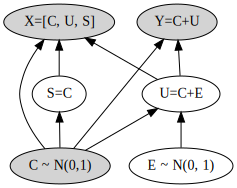

In [3]:
dot = Digraph()

dot.node('X', 'X=[C, U, S]', style='filled', fillcolor='lightgray')
dot.node('C', 'C ~ N(0,1)', style='filled', fillcolor='lightgray')
dot.node('Y', 'Y=C+U', style='filled', fillcolor='lightgray')
dot.node('U', 'U=C+E')
dot.node('E', 'E ~ N(0, 1)')
dot.node('S', 'S=C')
dot.edges(['UY', 'CY', 'CS', 'EU', 'SX', 'CX', 'UX', 'CU'])
# dot.edge('Z', 'S', style='dashed')

dot.graph_attr['rankdir'] = 'BT'
dot.render('figures/counter_example')
dot

This case is interesting b/c the problem is linear and U is correlated with S

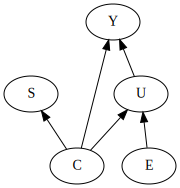

          C         U         S         E         Y
0  0.573164  0.952613  0.573164  0.379449  1.525778
1  0.787598  0.520743  0.787598 -0.266854  1.308341
2  0.957371  2.187539  0.957371  1.230168  3.144910
3  0.784438  1.100282  0.784438  0.315844  1.884720
4  0.637838  0.758562  0.637838  0.120724  1.396400
5  0.717666  0.990043  0.717666  0.272377  1.707710
6  0.445947  0.469163  0.445947  0.023216  0.915109
7  1.334607  1.162876  1.334607 -0.171732  2.497483
8  0.275648  0.410347  0.275648  0.134698  0.685995
9  0.520780 -0.829010  0.520780 -1.349790 -0.308230


,C,U,S,E,Y
0,-0.854294,-0.250832,0.0,0.603462,-1.105125
1,1.224462,1.587962,0.0,0.363500,2.812424
2,0.662578,-0.259890,0.0,-0.922468,0.402689
3,-1.039793,-1.022780,0.0,0.017012,-2.062573
4,-1.112501,0.360336,0.0,1.472837,-0.752165
5,-0.037169,1.945793,0.0,1.982962,1.908625
6,1.360266,0.370081,0.0,-0.990185,1.730347
7,0.321274,-1.016379,0.0,-1.337653,-0.695104
8,-0.600302,-1.831532,0.0,-1.231231,-2.431834
9,-0.050873,1.021264,0.0,1.072137,0.970392


In [26]:
def build_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    c = Node('C')
    e = Node('E')
    s = Node('S', lambda c: c, [c])
    u = Node('U', lambda c, e: c + e, [c, e])
    y  = Node('Y', lambda c, u: c+u,
              [c, u], is_target_node=True)
    
    # initialize the values from data
    graph = Graph([c, u, s, e, y])   
    return graph

graph = build_graph() # the causal graph
graph.draw()
n = 10
print(sample_graph(graph, {'C': np.random.randn(n), 'E': np.random.randn(n)})[['C', 'U', 'S', 'E', 'Y']])
sample_graph(graph, {'C': np.random.randn(n), 'E': np.random.randn(n), 'S': np.zeros(n)})[['C', 'U', 'S', 'E', 'Y']]

In [28]:
n = 100000
bs = 100
wd = 1e-4

XYC = sample_graph(graph, {'C': np.random.randn(n), 'E': np.random.randn(n)})[['C', 'U', 'S', 'Y']]
XYC_te = sample_graph(graph, {'C': np.random.randn(n), 'E': np.random.randn(n)})[['C', 'U', 'S', 'Y']]
XYC_deploy = sample_graph(graph, {'C': np.random.randn(n), 'E': np.random.randn(n), 'S': np.zeros(n)})[['C', 'U', 'S', 'Y']]

def get_X_Y_C(XYC):
    X = np.array(XYC[['C', 'U', 'S']])
    Y = np.array(XYC[['Y']])
    C = np.array(XYC[['C']])
    return torch.from_numpy(X).float(), torch.from_numpy(Y).float(), torch.from_numpy(C).float()

X, Y, C = get_X_Y_C(XYC)
d = X.shape[1]
X_te, Y_te, C_te = get_X_Y_C(XYC_te)
X_de, Y_de, C_de = get_X_Y_C(XYC_deploy)
r = torch.zeros(d) # concept mask
r[0] = 1

# accuracy
mse_criterion = lambda o, y: F.mse_loss(o, y)

# dataset
loader_xy = DataLoader(TensorDataset(X, Y), batch_size=bs, shuffle=True) # regular dataset
loader_xy_te = DataLoader(TensorDataset(X_te, Y_te), batch_size=bs, shuffle=False) # regular dataset
loader_xy_de = DataLoader(TensorDataset(X_de, Y_de), batch_size=bs, shuffle=False) # regular dataset

train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1018.95it/s]


epoch   0: loss 6.822e+00


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1025.66it/s]


epoch   1: loss 6.585e-01


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1025.39it/s]


epoch   2: loss 5.972e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1038.90it/s]


epoch   3: loss 1.484e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1033.05it/s]


epoch   4: loss 2.009e-03


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1039.26it/s]


epoch   5: loss 8.217e-05


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1031.41it/s]


epoch   6: loss 5.090e-07


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1027.38it/s]


epoch   7: loss 1.586e-09


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1031.50it/s]


epoch   8: loss 1.248e-09


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1035.87it/s]


epoch   9: loss 1.239e-09


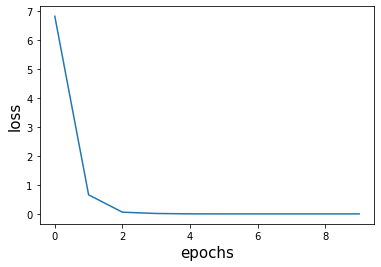

In [32]:
def standard_model(loader_xy, d, n_epochs=10, report_every=1, plot=True, weight_decay=0):
    # regular model
    net = MLP([d, 1])
    
    # train
    opt = optim.Adam(net.parameters(), weight_decay=weight_decay)
    log = train(net, loader_xy, opt, n_epochs=n_epochs, report_every=report_every, criterion=nn.MSELoss())
    if plot: plot_log(log)
    return net

n_epochs = 10
STD = standard_model(loader_xy, d, n_epochs=n_epochs, report_every=max(n_epochs//10,1), weight_decay=wd)

In [33]:
# ['C', 'U', 'S']
list(STD.classifier[0].parameters())

[Parameter containing:
 tensor([[0.5526, 1.0000, 0.4474]], requires_grad=True),
 Parameter containing:
 tensor([-1.7146e-06], requires_grad=True)]

train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 555.01it/s]


epoch   0: loss 4.023e+00


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 669.56it/s]


epoch   1: loss 1.942e-01


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 830.49it/s]


epoch   2: loss 1.741e-02


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 835.28it/s]


epoch   3: loss 1.599e-02


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 831.77it/s]


epoch   4: loss 1.580e-02


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 834.66it/s]


epoch   5: loss 1.570e-02


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 833.38it/s]


epoch   6: loss 1.556e-02


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 834.21it/s]


epoch   7: loss 1.532e-02


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 833.01it/s]


epoch   8: loss 1.495e-02


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 831.11it/s]


epoch   9: loss 1.438e-02


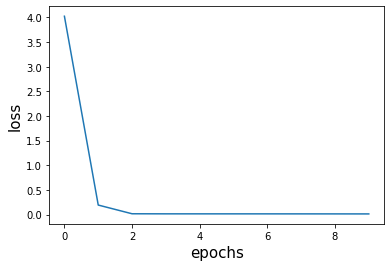

In [116]:
def CCM(loader_xy, r, n_epochs=10, report_every=1, plot=True, weight_decay=0):
    # regular model
    net = MLP([len(r), 1])

    # train
    criterion = lambda o_y, y: F.mse_loss(o_y, y) + 5e-3 * EYE(r, net.classifier[0].weight.abs().sum(0))
    # criterion = lambda o_y, y: F.mse_loss(o_y, y) + 0.1 * wL2(r, net.classifier[0].weight.abs().sum(0))

    opt = optim.Adam(net.parameters(), weight_decay=weight_decay)
    log = train(net, loader_xy, opt, n_epochs=n_epochs, report_every=report_every, criterion=criterion)
    if plot: plot_log(log)
    return net

n_epochs = 10
ccm = CCM(loader_xy, r, n_epochs=n_epochs, report_every=max(n_epochs//10,1), weight_decay=wd)

In [117]:
# ['C', 'U', 'S']
list(ccm.classifier[0].parameters())

[Parameter containing:
 tensor([[0.6773, 0.9982, 0.3216]], requires_grad=True),
 Parameter containing:
 tensor([-0.0002], requires_grad=True)]

train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 818.30it/s]


epoch   0: loss 7.487e+00


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 983.34it/s]


epoch   1: loss 3.879e+00


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 987.85it/s]


epoch   2: loss 2.016e+00


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 963.22it/s]


epoch   3: loss 1.240e+00


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 937.06it/s]


epoch   4: loss 1.029e+00


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 990.56it/s]


epoch   5: loss 1.002e+00


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 989.71it/s]


epoch   6: loss 1.000e+00


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 982.49it/s]


epoch   7: loss 1.000e+00


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 958.58it/s]


epoch   8: loss 1.000e+00


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 934.61it/s]


epoch   9: loss 1.000e+00


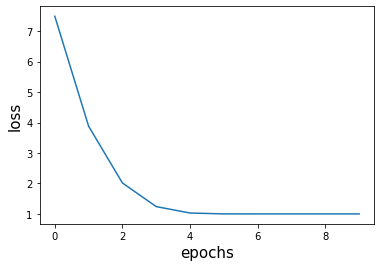

In [36]:
def CBM(loader_xy, r, n_epochs=10, report_every=1, plot=True, weight_decay=0):
    net = nn.Sequential(SubColumnNet(r.bool()), MLP([int(sum(r).item()), 1]))

    # train
    opt = optim.Adam(net.parameters(), weight_decay=weight_decay)
    log = train(net, loader_xy, opt, n_epochs=n_epochs, report_every=report_every, criterion=nn.MSELoss())
    if plot: plot_log(log)
    return net

n_epochs = 10
cbm = CBM(loader_xy, r, n_epochs=n_epochs, report_every=max(n_epochs//10,1), weight_decay=wd)

In [37]:
list(cbm[1].classifier[0].parameters())

[Parameter containing:
 tensor([[2.0140]], requires_grad=True),
 Parameter containing:
 tensor([-0.0061], requires_grad=True)]

train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 756.16it/s]


epoch   0: loss 5.057e-01


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 907.13it/s]


epoch   1: loss 3.039e-02


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 913.03it/s]


epoch   2: loss 2.722e-04


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 915.18it/s]


epoch   3: loss 1.189e-07


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 835.58it/s]


epoch   4: loss 6.370e-09


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 918.23it/s]


epoch   5: loss 6.327e-09


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 917.58it/s]


epoch   6: loss 6.333e-09


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 852.95it/s]


epoch   7: loss 6.388e-09


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 915.43it/s]


epoch   8: loss 6.390e-09


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 928.19it/s]


epoch   9: loss 6.412e-09


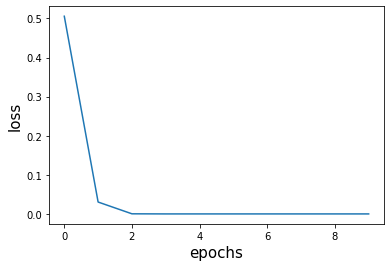

In [46]:
def Res(loader_xy, cbm, d, n_epochs=10, report_every=1, plot=True, weight_decay=0):
    net = MLP([d, 1])    
    net = CCM_res(cbm, net)

    # train
    opt = optim.Adam(net.parameters(), weight_decay=weight_decay)
    # opt = optim.SGD(net.parameters(), lr=0.01, weight_decay=weight_decay)
    log = train(net, loader_xy, opt, n_epochs=n_epochs, report_every=report_every, criterion=nn.MSELoss())
    if plot: plot_log(log)
    return net

n_epochs = 10
res = Res(loader_xy, cbm, d, n_epochs=n_epochs, report_every=max(n_epochs//10,1), weight_decay=wd)

In [47]:
list(res.net2.classifier[0].parameters())

[Parameter containing:
 tensor([[-0.5249,  0.9999, -0.4890]], requires_grad=True),
 Parameter containing:
 tensor([0.0061], requires_grad=True)]

In [114]:
print('Before distribution shift')
print('task mse EYE after training: {:.1e}'.format(test(ccm, loader_xy_te, mse_criterion)))
print('task mse RES after training: {:.1e}'.format(test(res, loader_xy_te, mse_criterion)))
print('task mse CBM after training: {:.1e}'.format(test(cbm, loader_xy_te, mse_criterion)))
print('task mse STD(X) after training: {:.1e}'.format(test(STD, loader_xy_te, mse_criterion)))

Before distribution shift


test eval: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1161.10it/s]


task mse EYE after training: 8.7e-03


test eval: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1306.15it/s]


task mse RES after training: 7.0e-09


test eval: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1503.63it/s]


task mse CBM after training: 1.0e+00


test eval: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1583.05it/s]

task mse STD(X) after training: 1.1e-09


In [115]:
print('After distribution shift')
print('task mse EYE after training: {:.1e}'.format(test(ccm, loader_xy_de, mse_criterion)))
print('task mse RES after training: {:.1e}'.format(test(res, loader_xy_de, mse_criterion)))
print('task mse CBM after training: {:.1e}'.format(test(cbm, loader_xy_de, mse_criterion)))
print('task mse STD(X) after training: {:.1e}'.format(test(STD, loader_xy_de, mse_criterion)))

After distribution shift


test eval: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1475.95it/s]


task mse EYE after training: 8.7e-03


test eval: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1363.49it/s]


task mse RES after training: 2.4e-01


test eval: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1504.38it/s]


task mse CBM after training: 1.0e+00


test eval: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1594.49it/s]

task mse STD(X) after training: 2.0e-01
